In [ ]:

import os

base_dir = "/content/drive/MyDrive/Projects/ANPRDataset"

folders = {
    "google_images": os.path.join(base_dir, "google_images"),
    "statewise_olx": os.path.join(base_dir, "State-wise_OLX"),
    "video_images": os.path.join(base_dir, "video_images")
}

def count_files(path, recursive=False):
    count = 0
    if recursive:
        for root, _, files in os.walk(path):
            count += len(files)
    else:
        count = len(os.listdir(path))
    return count

# -----------------------------
# Count
# -----------------------------
print("📂 Dataset folder sizes:\n")

# Google images (flat folder)
print(f"google_images: {count_files(folders['google_images'])} files")

# State-wise OLX (with subfolders)
for state in os.listdir(folders['statewise_olx']):
    state_path = os.path.join(folders['statewise_olx'], state)
    if os.path.isdir(state_path):
        print(f"  {state}: {count_files(state_path)} files")

print(f"TOTAL statewise_olx: {count_files(folders['statewise_olx'], recursive=True)} files")

# Video images (flat folder)
print(f"video_images: {count_files(folders['video_images'])} files")


📂 Dataset folder sizes:

google_images: 883 files
  AN: 14 files
  AP: 74 files
  AR: 24 files
  AS: 48 files
  BR: 32 files
  CG: 38 files
  CH: 20 files
  DL: 70 files
  DN: 16 files
  GA: 26 files
  GJ: 54 files
  HP: 44 files
  HR: 44 files
  JH: 36 files
  JK: 66 files
  KA: 40 files
  KL: 26 files
  LA: 2 files
  MH: 49 files
  ML: 70 files
  MN: 10 files
  MP: 22 files
  MZ: 2 files
  NL: 16 files
  OD: 44 files
  PB: 54 files
  PY: 34 files
  RJ: 14 files
  SK: 26 files
  TN: 20 files
  TR: 20 files
  TS: 32 files
  UK: 20 files
  UP: 48 files
  WB: 50 files
TOTAL statewise_olx: 1205 files
video_images: 1308 files


In [ ]:
import os
import glob
import shutil
import random
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

# ============================
# Paths
# ============================
ROOT = "/content/drive/MyDrive/Projects/ANPRDataset"
OUT  = "/content/drive/MyDrive/Projects/ANPRDataset2025"

# Fresh start
if os.path.exists(OUT):
    shutil.rmtree(OUT)
for split in ["train", "val", "test"]:
    os.makedirs(f"{OUT}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT}/labels/{split}", exist_ok=True)

# ============================
# VOC → YOLO conversion
# ============================
def voc_to_yolo(xml_file, img_w, img_h):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    yolo_lines = []

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        if bbox is None:
            continue

        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        # Normalize
        cx = ((xmin + xmax) / 2) / img_w
        cy = ((ymin + ymax) / 2) / img_h
        w  = (xmax - xmin) / img_w
        h  = (ymax - ymin) / img_h

        # Class is always "0" (license_plate)
        yolo_lines.append(f"0 {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

    return yolo_lines

# ============================
# Collect all valid pairs
# ============================
all_pairs = []
img_exts = [".jpg", ".jpeg", ".png", ".bmp"]

for folder in ["google_images", "video_images", "State-wise_OLX"]:
    folder_path = os.path.join(ROOT, folder)

    # handle subfolders in State-wise_OLX
    if folder == "State-wise_OLX":
        img_files = []
        for state in os.listdir(folder_path):
            state_path = os.path.join(folder_path, state)
            img_files.extend(glob.glob(f"{state_path}/*"))
    else:
        img_files = glob.glob(f"{folder_path}/*")

    for img_file in img_files:
        if os.path.splitext(img_file)[1].lower() not in img_exts:
            continue

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        if os.path.exists(xml_file):
            all_pairs.append((img_file, xml_file))

print(f"✅ Found {len(all_pairs)} valid image-label pairs")

# ============================
# Split dataset
# ============================
train_pairs, temp_pairs = train_test_split(all_pairs, test_size=0.30, random_state=42)
val_pairs, test_pairs   = train_test_split(temp_pairs, test_size=0.50, random_state=42)

splits = {
    "train": train_pairs,
    "val": val_pairs,
    "test": test_pairs
}

# ============================
# Process & Save
# ============================
for split, pairs in splits.items():
    for img_file, xml_file in tqdm(pairs, desc=f"Processing {split}"):
        try:
            img = Image.open(img_file)
            w, h = img.size

            yolo_labels = voc_to_yolo(xml_file, w, h)
            if not yolo_labels:  # skip if no bbox
                continue

            # Copy image
            out_img = os.path.join(OUT, "images", split, os.path.basename(img_file))
            shutil.copy(img_file, out_img)

            # Save label
            out_label = os.path.join(OUT, "labels", split, os.path.splitext(os.path.basename(img_file))[0] + ".txt")
            with open(out_label, "w") as f:
                f.write("\n".join(yolo_labels))

        except Exception as e:
            print(f"⚠️ Error processing {img_file}: {e}")

# ============================
# Sanity Check
# ============================
def count_files(img_dir, lbl_dir):
    imgs = len(glob.glob(f"{img_dir}/*"))
    lbls = len(glob.glob(f"{lbl_dir}/*"))
    return imgs, lbls

print("\n📊 Final Sanity Check")
for split in ["train", "val", "test"]:
    imgs, lbls = count_files(f"{OUT}/images/{split}", f"{OUT}/labels/{split}")
    print(f"{split.upper()} → Images: {imgs} | Labels: {lbls}")


✅ Found 1698 valid image-label pairs


Processing test: 100%|██████████| 255/255 [00:07<00:00, 31.97it/s]



📊 Final Sanity Check
TRAIN → Images: 1188 | Labels: 1187
VAL → Images: 255 | Labels: 255
TEST → Images: 255 | Labels: 255


In [ ]:
!pip install ultralytics


In [ ]:
from ultralytics import YOLO

# Load pretrained YOLOv8-small model
model = YOLO("yolov8s.pt")

# Train on ANPR dataset (transfer learning)
model.train(
    data="/content/drive/MyDrive/Projects/ANPRDataset2025/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    patience=10,
    name="yolov8s-anpr",   # run folder name
    project="/content/drive/MyDrive/Projects/ANPRDataset2025",  # save here
    save_period=5          # saves weights every 5 epochs
)



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Projects/ANPRDataset2025/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s-anpr, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plot

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/drive/MyDrive/Projects/ANPRDataset2025/labels/train.cache... 1188 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1188/1188 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Projects/ANPRDataset2025/images/train/HP20.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0882]
train: /content/drive/MyDrive/Projects/ANPRDataset2025/images/train/car-wbs-MH03AR5549_00000.jpg: corrupt JPEG restored and saved


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.3 ms, read: 0.7±1.1 MB/s, size: 169.9 KB)


val: Scanning /content/drive/MyDrive/Projects/ANPRDataset2025/labels/val.cache... 255 images, 0 backgrounds, 0 corrupt: 100%|██████████| 255/255 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Projects/ANPRDataset2025/yolov8s-anpr/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/Projects/ANPRDataset2025/yolov8s-anpr
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.9683      1.566      1.012          6        640: 100%|██████████| 75/75 [52:11<00:00, 41.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:47<00:00, 13.46s/it]

                   all        255        255      0.851      0.827      0.866      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.9604      0.766      1.029          2        640: 100%|██████████| 75/75 [33:44<00:00, 26.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:52<00:00, 14.12s/it]

                   all        255        255      0.445      0.672      0.435      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.9697     0.7243      1.025          4        640: 100%|██████████| 75/75 [33:31<00:00, 26.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:54<00:00, 14.27s/it]

                   all        255        255      0.911      0.922      0.947      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.9884     0.7193      1.027          5        640: 100%|██████████| 75/75 [34:18<00:00, 27.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:50<00:00, 13.76s/it]

                   all        255        255      0.901      0.895      0.956      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.9378     0.6489      1.008          7        640: 100%|██████████| 75/75 [34:17<00:00, 27.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:54<00:00, 14.30s/it]

                   all        255        255       0.94      0.915      0.972      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.9301     0.6552      1.004          3        640: 100%|██████████| 75/75 [35:09<00:00, 28.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:53<00:00, 14.16s/it]

                   all        255        255      0.951      0.922      0.973      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.9047      0.636      1.006          7        640: 100%|██████████| 75/75 [32:54<00:00, 26.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:54<00:00, 14.28s/it]

                   all        255        255      0.954      0.929      0.966      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.8429     0.5745     0.9739          4        640: 100%|██████████| 75/75 [34:10<00:00, 27.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:50<00:00, 13.86s/it]

                   all        255        255      0.977      0.978      0.992      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.8515     0.5752     0.9653          7        640: 100%|██████████| 75/75 [35:01<00:00, 28.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:52<00:00, 14.06s/it]

                   all        255        255      0.981      0.941       0.99       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.8105     0.5403     0.9561          7        640: 100%|██████████| 75/75 [34:05<00:00, 27.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:54<00:00, 14.37s/it]

                   all        255        255      0.954      0.988       0.99      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.8046     0.5299     0.9574          5        640: 100%|██████████| 75/75 [34:15<00:00, 27.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:55<00:00, 14.41s/it]

                   all        255        255      0.954      0.973      0.991      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.8038     0.5112     0.9485          4        640: 100%|██████████| 75/75 [34:38<00:00, 27.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:51<00:00, 13.94s/it]

                   all        255        255      0.961       0.96      0.991        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.8072     0.5178     0.9617          7        640: 100%|██████████| 75/75 [34:24<00:00, 27.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:53<00:00, 14.19s/it]

                   all        255        255      0.957       0.95       0.98      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G       0.82     0.5217     0.9747          5        640: 100%|██████████| 75/75 [34:13<00:00, 27.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:55<00:00, 14.44s/it]

                   all        255        255      0.996      0.971      0.993      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.7495     0.4828     0.9319          7        640: 100%|██████████| 75/75 [34:54<00:00, 27.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:58<00:00, 14.81s/it]

                   all        255        255      0.966      0.984      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.7799     0.5002     0.9486          7        640: 100%|██████████| 75/75 [35:17<00:00, 28.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:55<00:00, 14.42s/it]

                   all        255        255      0.986       0.98      0.991      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.7568     0.4729     0.9334          4        640: 100%|██████████| 75/75 [34:55<00:00, 27.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:55<00:00, 14.38s/it]

                   all        255        255      0.972      0.965      0.989      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.7379     0.4659     0.9261          6        640: 100%|██████████| 75/75 [35:26<00:00, 28.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:55<00:00, 14.49s/it]

                   all        255        255      0.988      0.964      0.989      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.7408     0.4628     0.9364          5        640: 100%|██████████| 75/75 [36:01<00:00, 28.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [02:07<00:00, 15.90s/it]

                   all        255        255       0.98      0.962      0.992      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.7594     0.4403     0.9159         23        640:  15%|█▍        | 11/75 [05:29<31:02, 29.10s/it]


image 1/1 /content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/car1.jpeg: 416x640 1 license_plate, 587.7ms
Speed: 4.7ms preprocess, 587.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


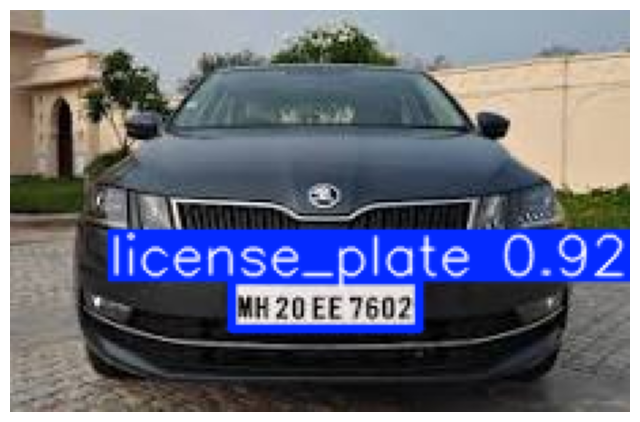

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load best model
model = YOLO("/content/drive/MyDrive/Projects/ANPRDataset2025/yolov8s-anpr/weights/best.pt")

# Input image
img_path = "/content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/car1.jpeg"

# Run prediction (no saving)
results = model.predict(
    source=img_path,
    conf=0.80,
    save=False   # do not save
)

# Display the first result
for r in results:
    # r.plot() returns an array (BGR image with boxes+labels drawn)
    im_bgr = r.plot()
    im_rgb = im_bgr[..., ::-1]  # convert BGR to RGB

    plt.figure(figsize=(8, 6))
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.show()


In [ ]:
!pip install pytesseract


image 1/1 /content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/car1.jpeg: 416x640 1 license_plate, 371.2ms
Speed: 3.0ms preprocess, 371.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
Extracted Plate Text: WH 20EE 7602


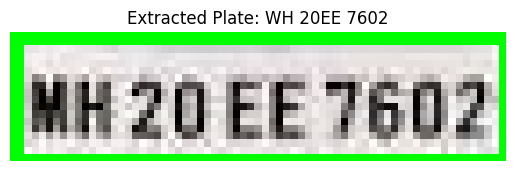

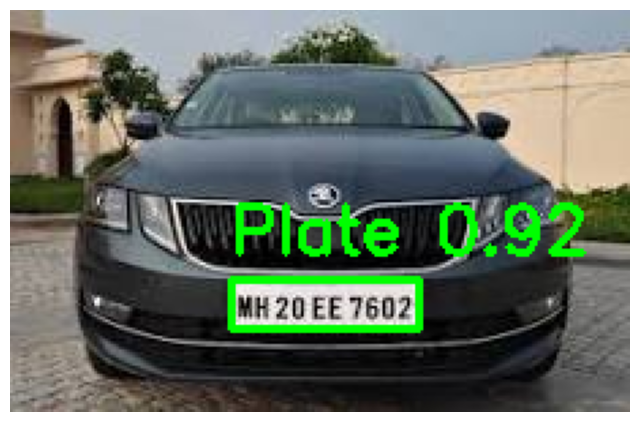

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import pytesseract

# Path to Tesseract executable (needed on Windows, skip in Colab/Linux if already installed)
# Example for Windows:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load YOLOv8 model
model = YOLO("/content/drive/MyDrive/Projects/ANPRDataset2025/yolov8s-anpr/weights/best.pt")

# Input image
img_path = "/content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/car1.jpeg"

# Run prediction
results = model.predict(
    source=img_path,
    conf=0.80,
    save=False
)

# Load original image
image = cv2.imread(img_path)

for r in results:
    for box in r.boxes:
        cls_id = int(box.cls[0].item())   # class id
        conf = float(box.conf[0].item()) # confidence
        xyxy = box.xyxy[0].cpu().numpy().astype(int)  # [x1, y1, x2, y2]

        # Draw detection
        cv2.rectangle(image, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
        cv2.putText(image, f"Plate {conf:.2f}", (xyxy[0], xyxy[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # --- OCR on detected plate ---
        plate_crop = image[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
        gray_plate = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray_plate, config="--psm 7")
        print("Extracted Plate Text:", text.strip())

        # Show extracted plate region
        plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Extracted Plate: {text.strip()}")
        plt.axis("off")
        plt.show()

# Show final image with detection
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
from ultralytics import YOLO
import cv2
import os
import pytesseract
import csv
from datetime import datetime, timedelta

# Load YOLO model
model = YOLO("/content/drive/MyDrive/Projects/ANPRDataset2025/yolov8s-anpr/weights/best.pt")

# Input video
video_path = "/content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/video1.mp4"
save_dir = os.path.dirname(video_path)
output_video = os.path.join(save_dir, "video_with_plates1.mp4")
csv_file = os.path.join(save_dir, "detected_plates1.csv")

# Define start time of video (example: recording started now)
video_start_time = datetime.now()

# Open CSV for logging
csv_header = ["car_id", "frame_no", "entry_time", "date_time", "confidence", "x1", "y1", "x2", "y2", "plate_text"]
with open(csv_file, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)

# Tracking dictionary
tracked_cars = {}

# Open video
cap = cv2.VideoCapture(video_path)
fps = cap.get(5)  # frames per second
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, int(fps), (int(cap.get(3)), int(cap.get(4))))

frame_no = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_no += 1

    # Run YOLO detection with tracking
    results = model.track(frame, conf=0.70, persist=True, verbose=False)

    for r in results:
        if r.boxes.id is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        confs = r.boxes.conf.cpu().numpy()
        ids = r.boxes.id.cpu().numpy().astype(int)

        for box, conf, car_id in zip(boxes, confs, ids):
            x1, y1, x2, y2 = box
            plate_crop = frame[y1:y2, x1:x2]

            plate_text = ""
            if plate_crop.size > 0:
                plate_text = pytesseract.image_to_string(plate_crop, config="--psm 7")
                plate_text = "".join(ch for ch in plate_text.strip().upper() if ch.isalnum() or ch == " ")

            # Calculate entry time (in seconds -> HH:MM:SS)
            entry_sec = frame_no / fps
            hrs = int(entry_sec // 3600)
            mins = int((entry_sec % 3600) // 60)
            secs = int(entry_sec % 60)
            entry_time = f"{hrs:02d}:{mins:02d}:{secs:02d}"

            # Calculate real-world datetime
            entry_datetime = video_start_time + timedelta(seconds=entry_sec)
            entry_datetime_str = entry_datetime.strftime("%Y-%m-%d %H:%M:%S")

            if car_id in tracked_cars:
                if conf > tracked_cars[car_id]["conf"]:
                    tracked_cars[car_id] = {
                        "conf": conf,
                        "frame": frame_no,
                        "time": entry_time,
                        "datetime": entry_datetime_str,
                        "bbox": (x1, y1, x2, y2),
                        "plate": plate_text
                    }
            else:
                tracked_cars[car_id] = {
                    "conf": conf,
                    "frame": frame_no,
                    "time": entry_time,
                    "datetime": entry_datetime_str,
                    "bbox": (x1, y1, x2, y2),
                    "plate": plate_text
                }

            # Draw bbox + OCR text + datetime
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID:{car_id} {plate_text}", (x1, y1 - 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.putText(frame, entry_datetime_str, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()

# Save best detections to CSV
with open(csv_file, mode="a", newline="") as f:
    writer = csv.writer(f)
    for car_id, data in tracked_cars.items():
        x1, y1, x2, y2 = data["bbox"]
        writer.writerow([car_id, data["frame"], data["time"], data["datetime"],
                         round(float(data["conf"]), 3), x1, y1, x2, y2, data["plate"]])

print(f"✅ Annotated video saved at: {output_video}")
print(f"✅ Plate details with entry date & time logged into: {csv_file}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

✅ Annotated video saved at: /content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/video_with_plates1.mp4
✅ Plate details with entry date & time logged into: /content/drive/MyDrive/Projects/ANPRDataset2025/RealTimeData/detected_plates1.csv
